In [1]:
import psycopg2
import pandas as pd
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt
import xlrd
import datetime
import time
import requests
from bs4 import BeautifulSoup

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [3]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [ ]:
start_date = '2021-03-01'
end_date = '2021-03-31'

In [4]:
query = """
select
    c.campaign_id
    , c.campaign_name
    , ctp.site_id
    , s.site_name
    , c.app_id
    , ctp.android_package_name
    , c.billing_type_id
    , c.house_ad
    , c.daily_budget
    , c.min_platform_os_version_id 
    , osv.osv
    , pi1.partner_name as carrier_name
    , pi2.partner_name as advertiser_name
    , count(distinct ctp.referrer) as preloads
    , count(distinct cti.referrer) as installs
from rawdata.campaign_tracking_active_preload ctp 
left join rawdata.campaign_tracking_active_install cti 
    on ctp.referrer = cti.referrer
join rawdata.campaign c 
    on c.campaign_id = ctp.campaign_id 
left join rawdata.site s
    on s.site_id = ctp.site_id
left join rawdata.partner_information pi1
    on pi1.partner_id = s.partner_id
left join rawdata.partner_app pa 
    on pa.id = c.app_id
    and pa.package_name = ctp.android_package_name
left join rawdata.partner_information pi2
    on pi2.partner_id = pa.partner_id 
left join
(
    select
        p.uid || '_' || t.transactionid as igniteID
        , max(dos.os) as osv 
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te 
        on t.transactionid = te.transactionid
    join rawdata.dt_events e
        on e.eventid = te.eventid 
        and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p
        on t.processid = p.processid 
        and p.rs_carrier_id = t.rs_carrier_id 
        and p.processtypeid = 1
    left join rawdata.dt_device_os dos
        on dos.deviceosid = p.deviceosid
        and dos.rs_carrier_id = p.rs_carrier_id 
    where 
        date(te.eventdate) >= date('{start_date}') - interval '30 day'
        and date(te.eventdate) <= '{end_date}'
    group by 1
) osv
    on ctp.reqid = osv.igniteid
where
    date(ctp.tracking_time) >= '{start_date}'
    and date(ctp.tracking_time) <= '{end_date}'
group by 
    c.campaign_id
    , c.campaign_name
    , ctp.site_id
    , s.site_name
    , c.app_id
    , ctp.android_package_name
    , ctp.mmppartner
    , c.billing_type_id
    , c.house_ad
    , c.daily_budget
    , c.min_platform_os_version_id 
    , osv.osv
    , pi1.partner_name 
    , pi2.partner_name 
"""

In [122]:
cur_atlas.execute(query)
df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [11]:
def osv_split(row, osv):
    if pd.isna(osv):
        return np.nan
    else:
        l = [int(x.replace('W','')) for x in str(osv).split('.') if x != 'nan']
        while len(l) < 3:
            l.append(0)
        return l

df['osv'].fillna(np.nan, inplace = True)
df['osv'].replace('O', np.nan, inplace = True)
df['osv_split'] = df.apply(lambda x:osv_split(x, x['osv']))

NameError: name 'df' is not defined

In [124]:
by_osv = df.fillna('null').pivot_table(values = ['preloads','installs'], index = 'osv', aggfunc = np.sum)
by_osv['cvr'] = round(by_osv['installs']/by_osv['preloads'],3) 
by_osv['sov'] = round(by_osv['preloads']/by_osv['preloads'].sum(),3)
by_osv.sort_values('preloads', ascending = False)

installs  preloads    cvr    sov
osv                                    
10     11289199  76563929  0.147  0.470
9       2950588  26239646  0.112  0.161
null    3616481  20376884  0.177  0.125
11       870791  12581481  0.069  0.077
8.1.0   1206082  10113940  0.119  0.062
8.0.0    647767   5524551  0.117  0.034
7.0      491485   4573218  0.107  0.028
7.1.1    263484   2700192  0.098  0.017
6.0.1    228657   1835393  0.125  0.011
6.0      135186   1153365  0.117  0.007
5.1.1     66713    539987  0.124  0.003
7.1.2     55482    531614  0.104  0.003
5.1       15664    154383  0.101  0.001
5.0.2      4519     42400  0.107  0.000
5.0.1       361      5093  0.071  0.000
5.0         289      3372  0.086  0.000
4.4.4        84      2280  0.037  0.000
8.0          30       281  0.107  0.000
8.1           1        19  0.053  0.000
0.0.0         0        12  0.000  0.000
11.0          0        10  0.000  0.000
9.0           2        10  0.200  0.000
4.4.2         0         7  0.000  0.000
12            0         7  0.000  0.000
7.0.1         1         6  0.167  0.000
6.1.1         0         5  0.000  0.000
6.0.0         0         5  0.000  0.000

In [125]:
min_osv_set = df.fillna('null').pivot_table(values = 'campaign_id', index = 'min_platform_os_version_id', aggfunc = lambda x:len(x.unique()))
min_osv_set['sov'] = min_osv_set.campaign_id/min_osv_set.campaign_id.sum()
min_osv_set.sort_values('sov', ascending=False)

campaign_id       sov
min_platform_os_version_id                       
null                               1528  0.694861
69.0                                141  0.064120
78.0                                114  0.051842
74.0                                108  0.049113
82.0                                 70  0.031833
47.0                                 58  0.026376
72.0                                 38  0.017281
90.0                                 37  0.016826
70.0                                 28  0.012733
7.0                                  23  0.010459
75.0                                 15  0.006821
71.0                                 10  0.004548
6.0                                   8  0.003638
4.0                                   8  0.003638
91.0                                  4  0.001819
105.0                                 2  0.000910
106.0                                 2  0.000910
3.0                                   2  0.000910
104.0                                 1  0.000455
103.0                                 1  0.000455
44.0                                  1  0.000455

In [126]:
def get_min_osv (row):
    app_id = row['app_id']
    url = 'https://play.google.com/store/apps/details?id='+app_id
    print('Running app id: '+str(app_id))
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    try:
        raw_osv = soup.body.find(text = 'Requires Android').parent.parent.span.div.span.text.split(' ')[0]
        print('Found min OS version:',str(raw_osv))
    except:
        print('URL not available - ',app_id)
        return 
    if raw_osv != 'Varies':
        osversion = osv_split(row, raw_osv)
    else:
        osversion = [0,0,0]
    return osversion

In [129]:
by_app = pd.DataFrame(df['android_package_name'].unique())
by_app.columns = ['app_id']
by_app['min_osv'] = by_app.apply(lambda x:get_min_osv(x), axis = 1)

Running app id: com.razer.cortex
Found min OS version: 7.1
Running app id: com.youmusic.magictiles
Found min OS version: 4.4
Running app id: com.king.farmheroessaga
Found min OS version: 4.1
Running app id: com.gsn.android.tripeaks
Found min OS version: 5.0
Running app id: com.king.candycrushsaga
Found min OS version: 4.1
Running app id: com.amanotes.pamarollingtiles2
Found min OS version: 4.4
Running app id: com.gramgames.mergedragons
Found min OS version: 4.1
Running app id: com.playstudios.popslots
Found min OS version: Varies
Running app id: com.pandora.android
Found min OS version: Varies
Running app id: com.agedstudio.card.spider.solitaire
Found min OS version: 4.4
Running app id: com.zhiliaoapp.musically
Found min OS version: 4.1
Running app id: com.moonactive.coinmaster
Found min OS version: 4.1
Running app id: com.zynga.gotslots
Found min OS version: 5.0
Running app id: com.pivotmobile.turtle
Found min OS version: 4.1
Running app id: com.champion.cubes
Found min OS version: 5.

Found min OS version: Varies
Running app id: com.staplegames.solitaireGP
Found min OS version: 4.4
Running app id: com.claro.claromusica.br
Found min OS version: 4.4
Running app id: com.weather.Weather
Found min OS version: Varies
Running app id: com.futureplay.city
Found min OS version: 4.4
Running app id: com.gameloft.android.gdc
URL not available -  com.gameloft.android.gdc
Running app id: com.pieyel.scrabble
Found min OS version: 5.0
Running app id: hn.com.tigosports
Found min OS version: 4.4
Running app id: com.medekhealth.medek
Found min OS version: 4.1
Running app id: com.telenav.app.android.uscc
Found min OS version: 5.0
Running app id: com.att.mobile.android.vvm
Found min OS version: 5.1
Running app id: com.rbt.android
Found min OS version: 4.4
Running app id: com.peoplefun.wordsearch
Found min OS version: 6.0
Running app id: com.scopely.startrek
Found min OS version: 4.4
Running app id: com.att.tv.watchtv
Found min OS version: 5.0
Running app id: com.tripledot.woodoku
Found m

Found min OS version: 4.4
Running app id: com.digitalturbine.android.apps.news.uscellular
Found min OS version: 6.0
Running app id: com.ea.gp.fifamobile
Found min OS version: 6.0
Running app id: com.mlstudio.burea
Found min OS version: 4.3
Running app id: io.voodoo.holeio
Found min OS version: 4.4
Running app id: com.Deven.Arrow3D
Found min OS version: 4.4
Running app id: tigosv.com.play
URL not available -  tigosv.com.play
Running app id: com.evernote
Found min OS version: Varies
Running app id: br.com.mobicare.net.wifi
Found min OS version: 4.1
Running app id: tigogt.com.play
URL not available -  tigogt.com.play
Running app id: com.calm.android
Found min OS version: Varies
Running app id: com.didiglobal.passenger
Found min OS version: 4.4
Running app id: com.pivotmobile.memorymatch
URL not available -  com.pivotmobile.memorymatch
Running app id: air.com.buffalo_studios.newflashbingo
Found min OS version: Varies
Running app id: com.thebonddigital.smag
URL not available -  com.thebondd

URL not available -  com.digitalturbine.android.apps.appshub.nokia
Running app id: io.voodoo.crowdcity
Found min OS version: 4.4
Running app id: com.grability.rappi
Found min OS version: 5.0
Running app id: com.adjust.examples
URL not available -  com.adjust.examples
Running app id: com.sliide.stub.a
URL not available -  com.sliide.stub.a
Running app id: com.glovo
Found min OS version: 5.0
Running app id: com.dg.differencegames.u.hiddenobject.fourseasons
Found min OS version: 4.4
Running app id: com.scientificgames.monopolyslots
Found min OS version: 4.1
Running app id: com.epicactiononline.ffxv.ane
Found min OS version: Varies
Running app id: com.waze
Found min OS version: 4.4
Running app id: ni.telefonica.mimovistar
Found min OS version: 5.0
Running app id: com.ketchapp.samuraislash
Found min OS version: 5.0
Running app id: com.juvomobileinc.tigoshop.bo
Found min OS version: 4.2
Running app id: com.stockwall.android
Found min OS version: 4.1
Running app id: com.etoro.openbook
Found m

Found min OS version: 4.1
Running app id: com.bigfishgames.gummydropgoogle
Found min OS version: 4.4
Running app id: com.antonio.thermo2.activity
URL not available -  com.antonio.thermo2.activity
Running app id: com.pivotmobile.android.notes
URL not available -  com.pivotmobile.android.notes
Running app id: com.northcube.sleepcycle
Found min OS version: 6.0
Running app id: jp.gungho.padEN
Found min OS version: 4.4
Running app id: com.emn8.mobilem8.nativeapp.popeyes
Found min OS version: 5.0
Running app id: com.adjust.insights
Found min OS version: 4.1
Running app id: com.att.trickshotkings
URL not available -  com.att.trickshotkings
Running app id: com.selfawaregames.acecasino
Found min OS version: 4.1
Running app id: com.weedmaps.app.android
Found min OS version: 7.0
Running app id: com.volpe.sudoku
URL not available -  com.volpe.sudoku
Running app id: air.com.sgn.cookiejam.gp
Found min OS version: 4.4
Running app id: tv.twitch.android.app
Found min OS version: 5.0
Running app id: in.

Found min OS version: 5.0
Running app id: com.listle.listleAndroid
URL not available -  com.listle.listleAndroid
Running app id: com.zazmic.SpaceSolitaire
URL not available -  com.zazmic.SpaceSolitaire
Running app id: com.veseystudios.veseyrewards
Found min OS version: 4.1
Running app id: com.ticno.olymptrade
Found min OS version: 5.0
Running app id: ph.com.smart.retailer
Found min OS version: 4.0.3
Running app id: com.indi.individuals
Found min OS version: 7.0
Running app id: com.shootbubble.bubbledexlue
Found min OS version: 1.1
Running app id: com.pocketcandy.diamondstrikefree
URL not available -  com.pocketcandy.diamondstrikefree
Running app id: com.overstock
Found min OS version: 5.1
Running app id: com.BuddyMattEnt.ChainReaction
Found min OS version: 4.0
Running app id: com.gamegos.mobile.manorcafe
Found min OS version: 4.1
Running app id: com.apalon.scanner.app
Found min OS version: 6.0
Running app id: mx.sindelantal.app
URL not available -  mx.sindelantal.app
Running app id: co

In [130]:
by_app['min_osv_str'] = by_app.loc[~by_app['min_osv'].isna(),'min_osv'].apply(lambda x:'.'.join([str(val) for val in x]))
by_app.fillna('null').groupby('min_osv_str').count().sort_values('app_id', ascending = False)

app_id  min_osv
min_osv_str                 
5.0.0           185      185
4.4.0           141      141
4.1.0            71       71
null             71       71
0.0.0            60       60
6.0.0            51       51
7.0.0            22       22
4.2.0            20       20
5.1.0            13       13
4.0.3            11       11
4.3.0             6        6
7.1.0             2        2
1.1.0             1        1
4.0.0             1        1
8.0.0             1        1

In [131]:
def osv_comparison (row):
    if (pd.isna(row['osv'])) or (row['min_osv'] == None):
        return -1 
    else:
        try:
            if row['min_osv'] <= row['osv_split']:
                return 1
            else:
                return 0
        except Exception as e:
            print(e)
            print(row['min_osv'], row['osv_split'])

df_joined = pd.merge(df, by_app, left_on = 'android_package_name', right_on = 'app_id', how = 'left')            
df_joined['osv_valid'] = df_joined.apply(lambda x:osv_comparison(x), axis = 1)
df_joined

campaign_id                                      campaign_name  \
0             32058  Razer Cortex-Android-16793-APAC&Africa_Ignite_CPP   
1             31931     Magic Tiles 3 - Android - 18024 - Tier 2 - CPI   
2             33514      fhs_co_android_preload_cpi_lowcpi-3076-Ignite   
3             26617  SolitaireTriPeaks-Android-15050-US_Cricket_Ign...   
4             32424        ccs_row_android_preload_cpi_bau-2511-Ignite   
...             ...                                                ...   
155468        33942            WackyRun_Android_18528_US_VZ_Ignite_CPI   
155469        33942            WackyRun_Android_18528_US_VZ_Ignite_CPI   
155470        33942            WackyRun_Android_18528_US_VZ_Ignite_CPI   
155471        33942            WackyRun_Android_18528_US_VZ_Ignite_CPI   
155472        33942            WackyRun_Android_18528_US_VZ_Ignite_CPI   

        site_id                                          site_name  app_id_x  \
0         12096  DT - Lava - Multi - Ignite - Benco AF9030 - Si...     16793   
1         10023         DT - DTOM - AMX - MX - Ignite - All Device     18024   
2         12082      DT - Millicom - CO - Ignite - Silent - Tier 2      3076   
3         11186  DT - Cricket - US - Ignite - Alcatel - ONYX - ...     15050   
4          9371        DT - DTOM - VZW - US - Ignite - All Devices      2511   
...         ...                                                ...       ...   
155468     9640  DT - Verizon - US - Ignite - LG Stylo 2 V - VS835     18528   
155469     9776      DT - Verizon - US - Ignite - LG - V20 - VS995     18528   
155470    10297  DT - Verizon - US - Ignite - Samsung - J3 Ecli...     18528   
155471    10922  DT - Verizon - US - Ignite - Samsung - J3 Miss...     18528   
155472    11870  DT - Verizon - US - Ignite - Samsung - A01 - S...     18528   

            android_package_name mmppartner  billing_type_id  house_ad  \
0               com.razer.cortex       None                2     False   
1        com.youmusic.magictiles       None                1     False   
2        com.king.farmheroessaga       None                1     False   
3       com.gsn.android.tripeaks       None                2     False   
4        com.king.candycrushsaga       None                1     False   
...                          ...        ...              ...       ...   
155468   com.h8games.DoodleRun3D       None                1     False   
155469   com.h8games.DoodleRun3D       None                1     False   
155470   com.h8games.DoodleRun3D       None                1     False   
155471   com.h8games.DoodleRun3D       None                1     False   
155472   com.h8games.DoodleRun3D       None                1     False   

       daily_budget  ...    osv            carrier_name     advertiser_name  \
0              None  ...      9                 DT Lava            DT Razer   
1              None  ...     10  DT Carrier Unallocated  Amanotes Pte. Ltd.   
2              None  ...      9             DT Millicom            King.com   
3              None  ...  8.1.0              DT Cricket           GSN Games   
4              None  ...     10  DT Carrier Unallocated            King.com   
...             ...  ...    ...                     ...                 ...   
155468         None  ...    NaN              DT Verizon              Voodoo   
155469         None  ...  8.0.0              DT Verizon              Voodoo   
155470         None  ...  8.1.0              DT Verizon              Voodoo   
155471         None  ...  8.0.0              DT Verizon              Voodoo   
155472         None  ...    NaN              DT Verizon              Voodoo   

       preloads  installs   osv_split                  app_id_y    min_osv  \
0          1687         0   [9, 0, 0]          com.razer.cortex  [7, 1, 0]   
1        200180     45167  [10, 0, 0]   com.youmusic.magictiles  [4, 4, 0]   
2          3783       903   [9, 0, 0]   com.king.farmheroessaga  [4, 1, 0]   
3       

In [133]:
df_joined['osv_major'] = df_joined.loc[~df_joined['osv_split'].isna(),'osv_split'].apply(lambda x:x[0])
df_joined.groupby('osv_major').count()

campaign_id  campaign_name  site_id  site_name  app_id_x  \
osv_major                                                             
0.0                 12             12       12         12        12   
4.0                 43             43       43         43        43   
5.0               3887           3887     3887       3887      3887   
6.0               8350           8350     8350       8350      8350   
7.0              16410          16410    16410      16410     16410   
8.0              18045          18045    18045      18045     18045   
9.0              21175          21175    21175      21175     21175   
10.0             30607          30607    30607      30607     30607   
11.0             12054          12054    12054      12054     12054   
12.0                 7              7        7          7         7   

           android_package_name  mmppartner  billing_type_id  house_ad  \
osv_major                                                                
0.0                          12           0               12        12   
4.0                          43           1               43        43   
5.0                        3887          58             3887      3887   
6.0                        8350         114             8350      8350   
7.0                       16410         267            16410     16410   
8.0                       18045         347            18045     18045   
9.0                       21175         450            21175     21175   
10.0                      30607         747            30607     30607   
11.0                      12054         236            12054     12054   
12.0                          7           0                7         7   

           daily_budget  ...    osv  carrier_name  advertiser_name  preloads  \
osv_major                ...                                                   
0.0                   0  ...     12            12               12        12   
4.0                   0  ...     43            43               43        43   
5.0                   0  ...   3887          3887             3887      3887   
6.0                   0  ...   8350          8350             8350      8350   
7.0                   0  ...  16410         16410            16410     16410   
8.0                   0  ...  18045         18045            18045     18045   
9.0                   0  ...  21175         21175            21175     21175   
10.0                  0  ...  30607         30607            30607     30607   
11.0                  0  ...  12054         12054            12054     12054   
12.0                  0  ...      7             7                7         7   

           installs  osv_split  app_id_y  min_osv  min_osv_str  osv_valid  
osv_major                                                                  
0.0              12         12        12       11           11         12  
4.0              43         43        43       43           43         43  
5.0            3887       3887      3887     3717         3717       3887  
6.0            8350       8350      8350     8031         8031       8350  
7.0           16410      16410     16410    15892        15892      16410  
8.0           18045      18045     18045    17526        17526      18045  
9.0           21175      21175     21175    20539        20539      21175  
10.0          30607      30607     30607    29970        29970      30607  
11.0          12054      12054     12054    11682        11682      12054  
12.0              7          7         7        7            7          7  

[10 rows x 21 columns]

In [136]:
pivot_osv_valid = df_joined.fillna('null').pivot_table(values = ['preloads','installs'], index = ['osv_valid'], aggfunc = np.sum)
pivot_osv_valid['preload_sov'] = round(pivot_osv_valid['preloads']/pivot_osv_valid['preloads'].sum(),4)
pivot_osv_valid

installs   preloads  preload_sov
osv_valid                                  
-1          4064396   34254079       0.2102
 0               11      14085       0.0001
 1         17778459  128673926       0.7897

In [137]:
pivot_osv_invalid = df_joined[df_joined.osv_valid  == -1].fillna('null').pivot_table(values = ['preloads','installs'], index = ['osv_valid','osv_major', 'min_osv_str'], aggfunc = np.sum)
pivot_osv_invalid['preload_sov'] = round(pivot_osv_invalid['preloads']/pivot_osv_invalid.preloads.sum(),3)
pivot_osv_invalid.sort_values('preloads', ascending = False)


installs  preloads  preload_sov
osv_valid osv_major min_osv_str                                 
-1        null      4.4.0         1450637   6386481        0.186
          10.0      null           336297   5764896        0.168
          null      5.0.0         1043730   5641397        0.165
                    4.1.0          780517   4381480        0.128
          9.0       null            25185   3190589        0.093
          8.0       null            23887   1978952        0.058
          null      0.0.0          203659   1701240        0.050
          7.0       null            35102   1391491        0.041
          11.0      null             1915   1033158        0.030
          null      6.0.0           64882    877458        0.026
                    null            27590    704605        0.021
          6.0       null            20372    424682        0.012
          null      5.1.0           33403    231056        0.007
                    7.0.0            2313    184350        0.005
                    7.1.0             161    164050        0.005
          5.0       null             5157     93426        0.003
          null      4.3.0            5688     62528        0.002
                    4.0.3            3858     30954        0.001
                    4.2.0              43     11234        0.000
                    8.0.0               0        51        0.000
          0.0       null                0         1        0.000

In [138]:
pivot_osv_valid = df_joined[df_joined.osv_valid == 1].pivot_table(values = ['preloads','installs'], index = ['osv_valid', 'min_osv_str'], aggfunc = np.sum).sort_values('preloads', ascending = False)
pivot_osv_valid['preload_sov'] = round(pivot_osv_valid['preloads']/pivot_osv_valid.preloads.sum(),3)
pivot_osv_valid

installs  preloads  preload_sov
osv_valid min_osv_str                                 
1         5.0.0         4949036  38883370        0.302
          4.1.0         4747930  30819936        0.240
          4.4.0         5352100  27129630        0.211
          0.0.0         2077739  15740791        0.122
          6.0.0          301817   8570749        0.067
          5.1.0          239234   2230516        0.017
          7.1.0             130   2228730        0.017
          7.0.0           24667   1476518        0.011
          4.0.3           59544    830027        0.006
          4.2.0            6076    588135        0.005
          4.3.0           20186    167812        0.001
          8.0.0               0      7710        0.000
          1.1.0               0         1        0.000
          4.0.0               0         1        0.000

Text(0.5, 1.0, 'OS versions served by # of preloads')

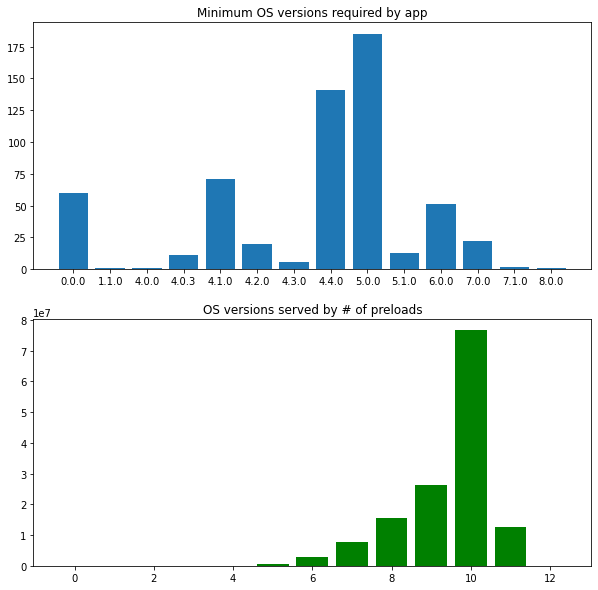

In [139]:
osv_mins_df = pd.DataFrame(df_joined.groupby('min_osv_str')['android_package_name'].nunique())
osv_mins_df.columns = ['apps']
fig, ax = plt.subplots(2,1, figsize = (10,10))

ax[0].bar(osv_mins_df.index, osv_mins_df['apps'])
ax[0].set_title('Minimum OS versions required by app')

by_osv = df_joined.pivot_table(values = ['preloads'], index = ['osv_major'], aggfunc = np.sum)
ax[1].bar(by_osv.index, by_osv['preloads'], color = 'green')
ax[1].set_title('OS versions served by # of preloads')

Text(0.5, 1.0, 'CVR by OS version')

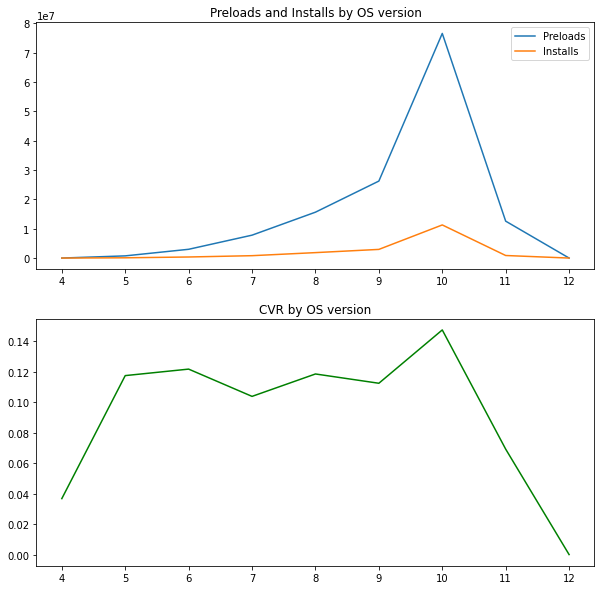

In [140]:
# CVR by os

pivot_osv = df_joined.pivot_table(values = ['preloads','installs'], index = 'osv_major', aggfunc = np.sum)
pivot_osv['cvr'] = pivot_osv['installs']/pivot_osv['preloads']
pivot_osv['sov'] = round(pivot_osv['preloads']/pivot_osv['preloads'].sum(),3)

fig, ax = plt.subplots(2,1, figsize = (10,10))
ax[0].plot(pivot_osv.loc[pivot_osv.index > 0, ['preloads','installs']])
ax[0].set_title('Preloads and Installs by OS version')
ax[0].legend(['Preloads','Installs'])
ax[1].plot(pivot_osv.loc[pivot_osv.index > 0, 'cvr'], color = 'green')
ax[1].set_title('CVR by OS version')

Text(0.5, 1.0, 'CVR by OS version, split by carrier')

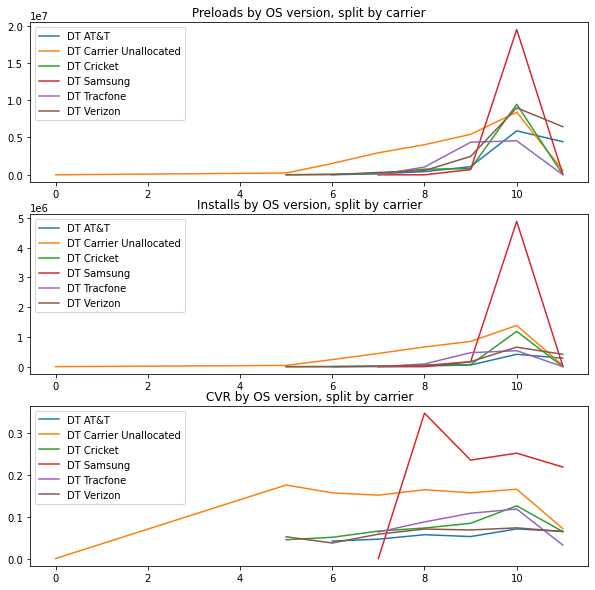

In [157]:
pivot_carrier_os = df_joined.pivot_table(values = ['preloads','installs'], index = ['carrier_name','osv_major'], aggfunc = np.sum)
pivot_carrier_os['cvr'] = pivot_carrier_os['installs']/pivot_carrier_os['preloads']
pivot_carrier_os = pivot_carrier_os[pivot_carrier_os.index.get_level_values(0).isin(['DT Samsung','DT Cricket','DT Verizon','DT AT&T','DT Tracfone','DT Carrier Unallocated'])]
pivot_carrier_os.reset_index(inplace = True)

fig, ax = plt.subplots(3,1, figsize = (10,10))
ax[0].plot(pivot_carrier_os.pivot_table(values = ['preloads'], index = 'osv_major', columns = 'carrier_name', aggfunc = np.sum))
ax[0].legend(pivot_carrier_os.carrier_name.unique())
ax[0].set_title('Preloads by OS version, split by carrier')
ax[1].plot(pivot_carrier_os.pivot_table(values = ['installs'], index = 'osv_major', columns = 'carrier_name', aggfunc = np.sum))
ax[1].legend(pivot_carrier_os.carrier_name.unique())
ax[1].set_title('Installs by OS version, split by carrier')
ax[2].plot(pivot_carrier_os.pivot_table(values = ['cvr'], index = 'osv_major', columns = 'carrier_name', aggfunc = 'mean'))
ax[2].legend(pivot_carrier_os.carrier_name.unique())
ax[2].set_title('CVR by OS version, split by carrier')

In [155]:
df_joined.pivot_table(values = ['preloads'], index = ['advertiser_name','android_package_name'], columns = 'osv_valid', aggfunc = np.sum).sort_values([('preloads',0),('preloads',1)], ascending = False).head(30)

preloads  \
osv_valid                                                                -1   
advertiser_name                android_package_name                           
Pivot Mobile                   com.amazon.mShop.android.shopping    42109.0   
DT Millicom                    com.amazon.mShop.android.shopping      215.0   
Voodoo                         com.KaueRosa.CityTakeover              228.0   
Adelantos Capital              com.adelantos.prestamos                625.0   
PeopleFun                      com.peoplefun.wordsearch              3942.0   
DT Razer                       com.razer.cortex                    163822.0   
Ketchapp                       com.ketchapp.artblitz                  311.0   
Wish                           com.contextlogic.wish               705423.0   
Pivot Mobile                   io.mobitech.newsme.dtopen             9381.0   
DT Blu                         com.huub.dolphin                        28.0   
King.com                       com.king.candycrushsaga            1086266.0   
                               com.king.farmheroessaga             252040.0   
Azur Interactive Games Limited com.azurgames.stackball             181546.0   
Amanotes Pte. Ltd.             com.amanotes.beathopper             856192.0   
DT America Movil MX            com.celltick.lockscreen              93323.0   
Amanotes Pte. Ltd.             com.youmusic.magictiles             157482.0   
Ilyon Dynamics                 challenge.hexa.boombox               83710.0   
Amanotes Pte. Ltd.             com.amanotes.pamacolorhop            66348.0   
Ilyon Dynamics                 onext.boombox                      1619752.0   
                               heroes.bubble.galaxy                 64995.0   
                               com.tap3.boombox                     86990.0   
                               com.champion.cubes                   57994.0   
SuperPlay                      com.superplaystudios.dicedreams       4117.0   
HomeAdvisor                    com.servicemagic.consumer             3645.0   
Taboola                        news.readerapp                         613.0   
US Cellular House              com.uscc.ecid                            5.0   
Snapchat                       com.snapchat.android                535887.0   
Particle Media                 com.particlenews.newsbreak          939609.0   
GSN Games                      com.gsn.android.tripeaks            155488.0   
TikTok- BR                     com.zhiliaoapp.musically             21305.0   

                                                                           \
osv_valid                                                               0   
advertiser_name                android_package_name                         
Pivot Mobile                   com.amazon.mShop.android.shopping  10725.0   
DT Millicom                    com.amazon.mShop.android.shopping   3175.0   
Voodoo                         com.KaueRosa.CityTakeover             77.0   
Adelantos Capital              com.adelantos.prestamos               44.0   
PeopleFun                      com.peoplefun.wordsearch              26.0   
DT Razer                       com.razer.cortex                      11.0   
Ketchapp                       com.ketchapp.artblitz                  5.0   
Wish                           com.contextlogic.wish                  2.0   
Pivot Mobile                   io.mobitech.newsme.dtopen              2.0   
DT Blu                         com.huub.dolphin                       2.0   
King.com                       com.king.candycrushsaga                1.0   
                               com.king.farmheroessaga                1.0   
Azur Interactive Games Limited com.azurgames.stackball                1.0   
Amanotes Pte. Ltd.             com.amanotes.beathopper                1.0   
DT America Movil MX            com.celltick.lockscreen                1.0   
Amanotes Pte. Ltd.             com.youmusic.magictiles                1.0

In [156]:
pivot_billing_type = df_joined.pivot_table(values = ['preloads','installs'], index = ['billing_type_id'], aggfunc = np.sum)
pivot_billing_type['cvr'] = pivot_billing_type['installs']/pivot_billing_type['preloads']
pivot_billing_type

installs   preloads       cvr
billing_type_id                               
1                17136889  110152650  0.155574
2                 4705977   52789440  0.089146

In [4]:
start_date = '2021-02-17'
end_date = '2021-03-12'
package_name = 'com.contextlogic.wish'

In [5]:
query_advertiser = """
select
    c.campaign_id
    , c.campaign_name
    , t.site_id
    , s.site_name
    , c.app_id
    , c.billing_type_id
    , c.house_ad
    , c.daily_budget
    , c.min_platform_os_version_id 
    , osv.osv
    , pi.partner_name as carrier_name
    , sum(spend) as spend
    , sum(preload) as preload
    , sum(install) as install
    , sum(d7_events) as d7_events
    , sum(d7_rev) as d7_rev
from
(
    select
        reqid
        , site_id
        , campaign_id
        , count(distinct referrer) as preload
        , 0 as install
        , 0 as d7_events
        , 0 as d7_rev
        , sum(case when billing_type = 'CPP' then gross_payout else 0 end) as spend 
    from rawdata.campaign_tracking_active_preload ctp
    where 
        date(tracking_time) >= date('{start_date}')
        and date(tracking_time) <= date('{end_date}')
        and android_package_name = '{package_name}'
        and right(referrer,1) = '0'
    group by 1,2,3

    union all

    select
        reqid
        , site_id
        , campaign_id
        , 0 as preload
        , count(distinct cti.referrer) as install
        , 0 as d7_events
        , 0 as d7_rev
        , sum(case when billing_type = 'CPI' then gross_payout else 0 end) as spend 
    from rawdata.campaign_tracking_active_install cti 
    where 
        date(cti.tracking_time) >= date('{start_date}')
        and date(cti.tracking_time) <= date('{end_date}')
        and android_package_name = '{package_name}'
        and right(referrer,1) = '0'
    group by 1,2,3

    union all 

    select
        cti.reqid
        , cti.site_id
        , cti.campaign_id
        , 0 as preload
        , 0 as install
        , count(distinct pi.referrer) as d7_events
        , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' then event_var else 0::varchar END) as d7_rev
        , 0 as spend 
    from rawdata.pi_data pi 
    join 
    (
        select 
            referrer 
            , reqid 
            , tracking_time 
            , cti.site_id
            , cti.campaign_id
        from rawdata.campaign_tracking_active_install cti 
        where 
            date(cti.tracking_time) >= date('{start_date}')
            and date(cti.tracking_time) <= date('{end_date}')
            and android_package_name = '{package_name}'
            and right(referrer,1) = '0'
        group by 1,2,3,4,5
    ) cti
        on cti.referrer = pi.referrer
        and pi.event_date <= cti.tracking_time + interval '7 day' 
        and pi.event_date >= cti.tracking_time 
    where 
        date(event_date) >= date('{start_date}')
        and date(event_date) <= date('{end_date}') + interval '7 day' 
        and right(pi.referrer,1) = '0'
        and pi.app_id = '{package_name}'
        and (lower(pi.event) like '%purchase%'
            or lower(pi.event) like '%order%'
            or lower(pi.event) like '%revenue%'
            or (event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$'
            and event_var != 0)) 
        and lower(pi.event) not like '%reorder%'
        and lower(pi.event) not like '%refund%'
        and lower(pi.event) not like '%cancel%'
    group by 1,2,3
) t
join rawdata.campaign c 
    on c.campaign_id = t.campaign_id 
left join rawdata.site s
    on s.site_id = t.site_id
left join rawdata.partner_information pi
    on pi.partner_id = s.partner_id
left join
(
    select
        p.uid || '_' || t.transactionid as igniteID
        , max(dos.os) as osv 
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te 
        on t.transactionid = te.transactionid
    join rawdata.dt_events e
        on e.eventid = te.eventid 
        and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p
        on t.processid = p.processid 
        and p.rs_carrier_id = t.rs_carrier_id 
        and p.processtypeid = 1
    left join rawdata.dt_device_os dos
        on dos.deviceosid = p.deviceosid
        and dos.rs_carrier_id = p.rs_carrier_id 
    where 
        date(te.eventdate) >= date('{start_date}') - interval '30 day'
        and date(te.eventdate) <= date('{end_date}')
    group by 1
) osv
    on t.reqid = osv.igniteid
group by 
    c.campaign_id
    , c.campaign_name
    , t.site_id
    , s.site_name
    , c.app_id
    , c.billing_type_id
    , c.house_ad
    , c.daily_budget
    , c.min_platform_os_version_id 
    , osv.osv
    , pi.partner_name
"""

In [6]:
df_list = []

for dt in pd.date_range(start = start_date, end = end_date, freq = '3D'):
    start_dt = dt.strftime('%Y-%m-%d')
    end_dt = min(end_date,(dt+datetime.timedelta(days = 2)).strftime('%Y-%m-%d'))
    print('Running query for date range:',start_dt, end_dt)
    try:
        cur_atlas.execute(query_advertiser.format(start_date = start_dt, end_date = end_dt, package_name = package_name))
        df_list.append(pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description]))
    except Exception as e:
        print('Error with date range:', start_dt, end_dt)
        print(e)

df_advertiser = pd.concat(df_list)
df_advertiser

Running query for date range: 2021-02-17 2021-02-19
Running query for date range: 2021-02-20 2021-02-22
Running query for date range: 2021-02-23 2021-02-25
Running query for date range: 2021-02-26 2021-02-28
Running query for date range: 2021-03-01 2021-03-03
Running query for date range: 2021-03-04 2021-03-06
Error with date range: 2021-03-04 2021-03-06
abort query
DETAIL:  
  -----------------------------------------------
  error:  abort query
  code:      1020
  context:   system requested abort
  query:     22135873
  location:  queryabort.hpp:84
  process:   padbmaster [pid=31851]
  -----------------------------------------------


Running query for date range: 2021-03-07 2021-03-09
Error with date range: 2021-03-07 2021-03-09
current transaction is aborted, commands ignored until end of transaction block

Running query for date range: 2021-03-10 2021-03-12
Error with date range: 2021-03-10 2021-03-12
current transaction is aborted, commands ignored until end of transaction block

campaign_id                                      campaign_name  site_id  \
0           28266            Wish-Android-9425-AR-Samsung-Ignite-CPI    11640   
1           25574                Wish-Android-9425-CO-AMX-Ignite-CPI    11794   
2           32579     Wish-Android-9425-BR-Samsung-Silent-Ignite-CPI    12032   
3           23906           Wish-Android-9425-US-Cricket-Ignite-CPI     11918   
4           25573                Wish-Android-9425-BR-AMX-Ignite-CPI    11794   
...           ...                                                ...      ...   
1834        23906           Wish-Android-9425-US-Cricket-Ignite-CPI     10385   
1835        28292                Wish-Android-9425-MX-AMX-Ignite-CPI     9372   
1836        23906           Wish-Android-9425-US-Cricket-Ignite-CPI     11172   
1837        25578  Wish-Android-9425-Europe-Lenovo-Archos-BLU-Ace...    10856   
1838        25573                Wish-Android-9425-BR-AMX-Ignite-CPI    11793   

                                              site_name  app_id  \
0       DT - Samsung - AR - Ignite - A-Series - AppList    9425   
1          DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD    9425   
2          DT - Samsung - BR - Ignite - Tier 2 - Silent    9425   
3     DT - Cricket - US - Ignite - LG - Fortune 3 - ...    9425   
4          DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD    9425   
...                                                 ...     ...   
1834  DT - Cricket - US - Ignite - ZTE - Blade X - Z...    9425   
1835       DT - DTOM - USCC - US - Ignite - All Devices    9425   
1836  DT - Cricket - US - Ignite - Samsung - Galaxy ...    9425   
1837          DT - Acer - Ignite - Acer B3-A42 - Silent    9425   
1838      DT - DTOM - CRKT OM - US - Ignite - RDNS BYOD    9425   

      billing_type_id  house_ad daily_budget  min_platform_os_version_id  \
0                   1     False         None                         NaN   
1                   1     False         None                        69.0   
2                   1     False         None                         NaN   
3                   1     False         None                        69.0   
4                   1     False         None                        69.0   
...               ...       ...          ...                         ...   
1834                1     False         None                        69.0   
1835                1     False         None                        74.0   
1836                1     False         None                        69.0   
1837                1     False         None                        69.0   
1838                1     False         None                        69.0   

        osv            carrier_name    spend  preload  install  d7_events  \
0        10              DT Samsung  29.7000      526      198          1   
1         9  DT Carrier Unallocated   9.5000      193       38          0   
2         9              DT Samsung   4.4000      106       22          0   
3        10              DT Cricket  86.8000      192       62          1   
4        10  DT Carrier Unallocated  15.4000      236       44          0   
...     ...                     ...      ...      ...      ...        ...   
1834   None              DT Cricket   0.0000        1        0          0   
1835  7.1.1  DT Carrier Unallocated   0.0000        1        0          0   
1836      9              DT Cricket   0.0000        1        0          0   
1837    7.0                 DT Acer   0.0000        1        0          0   
1838  7.1.1  DT Carrier Unallocated   1.2500        1        1          0   

     d7_rev  
0        15  
1         0  
2         0  
3        12  
4         0  
...     ...  
1834      0  
1835      0  
1836      0  
1837      0  
1838      0  

[9053 rows x 16 columns]

In [12]:
#df_advertiser.reset_index(inplace = True)
def osv_split(row, osv):
    if pd.isna(osv):
        return np.nan
    else:
        l = [int(x.replace('W','')) for x in str(osv).split('.') if x != 'nan']
        while len(l) < 3:
            l.append(0)
        return l

df_advertiser['spend'] = df_advertiser['spend'].astype('float')
df_advertiser['d7_rev'] = df_advertiser['d7_rev'].astype('float')
df_advertiser['osv'].fillna(np.nan, inplace = True)
df_advertiser['osv'].replace('O', np.nan, inplace = True)
df_advertiser['osv_split'] = df_advertiser.apply(lambda x:osv_split(x, x['osv']), axis = 1)
df_advertiser['osv_major'] = df_advertiser.loc[~df_advertiser['osv_split'].isna(),'osv_split'].apply(lambda x:x[0])
df_advertiser.head(30)

level_0  index  campaign_id  \
0         0      0        28266   
1         1      1        25574   
2         2      2        32579   
3         3      3        23906   
4         4      4        25573   
5         5      5        29653   
6         6      6        24236   
7         7      7        27710   
8         8      8        26563   
9         9      9        28292   
10       10     10        25574   
11       11     11        30752   
12       12     12        23904   
13       13     13        23906   
14       14     14        26563   
15       15     15        26563   
16       16     16        23904   
17       17     17        26563   
18       18     18        25088   
19       19     19        23904   
20       20     20        28292   
21       21     21        23904   
22       22     22        23904   
23       23     23        30752   
24       24     24        23906   
25       25     25        25088   
26       26     26        23904   
27       27     27        25088   
28       28     28        26685   
29       29     29        30306   

                                        campaign_name  site_id  \
0             Wish-Android-9425-AR-Samsung-Ignite-CPI    11640   
1                 Wish-Android-9425-CO-AMX-Ignite-CPI    11794   
2      Wish-Android-9425-BR-Samsung-Silent-Ignite-CPI    12032   
3            Wish-Android-9425-US-Cricket-Ignite-CPI     11918   
4                 Wish-Android-9425-BR-AMX-Ignite-CPI    11794   
5             Wish-Android-9425-TR-Samsung-Ignite-CPI    11880   
6                Wish-Android-9425-US-USCC-Ignite-CPI    11318   
7                    Wish-Android-16300-LatAm_Samsung    11667   
8            Wish-Android-9425-US-Tracfone-Ignite-CPI    12419   
9                 Wish-Android-9425-MX-AMX-Ignite-CPI    10023   
10                Wish-Android-9425-CO-AMX-Ignite-CPI    12611   
11                Wish-Android-9425-MX-ATT-Ignite-CPI    12380   
12                Wish-Android-9425-US-VZW-Ignite-CPI    11909   
13           Wish-Android-9425-US-Cricket-Ignite-CPI     12135   
14           Wish-Android-9425-US-Tracfone-Ignite-CPI    11656   
15           Wish-Android-9425-US-Tracfone-Ignite-CPI    12419   
16                Wish-Android-9425-US-VZW-Ignite-CPI    11275   
17           Wish-Android-9425-US-Tracfone-Ignite-CPI    12468   
18                 Wish-Android-9425-US-OM-Ignite-CPI    10492   
19                Wish-Android-9425-US-VZW-Ignite-CPI    11141   
20                Wish-Android-9425-MX-AMX-Ignite-CPI     9898   
21                Wish-Android-9425-US-VZW-Ignite-CPI    10831   
22                Wish-Android-9425-US-VZW-Ignite-CPI    11036   
23                Wish-Android-9425-MX-ATT-Ignite-CPI    12368   
24           Wish-Android-9425-US-Cricket-Ignite-CPI     11972   
25                 Wish-Android-9425-US-OM-Ignite-CPI    11795   
26                Wish-Android-9425-US-VZW-Ignite-CPI    11257   
27                 Wish-Android-9425-US-OM-Ignite-CPI    11016   
28  Wish-Android-9425-BE-Lenovo-Archos-Acer-Blu-Ig...    11500   
29           Wish-Android-9425-CO-Millicom-Ignite-CPI    11568   

                                            site_name  app_id  \
0     DT - Samsung - AR - Ignite - A-Series - AppList    9425   
1        DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD    9425   
2        DT - Samsung - BR - Ignite - Tier 2 - Silent    9425   
3   DT - Cricket - US - Ignite - LG - Fortune 3 - ...    9425   
4        DT - DTOM - AMX OM - MX - Ignite - RDNS BYOD    9425   
5     DT - Samsung - TR - Ignite - A-Series - AppList    9425   
6   DT - US Cellular - US - Ignite - LG MH1 - LMX2...    9425   
7     DT - Samsung - PE - Ignite - A-Series - AppList   16300   
8           DT - Tracfone - Ignite - Samsung - S515DL    9425   
9          DT - DTOM - AMX - MX - Ignite - All Device    9425   
10      DT - DTOM - AMX - Non MX - Ignite - RDNS BYOD    9425   
11  DT - ATT MX - Ignite - ZTE - Blade A7 2020 - S...    9425   
12  DT - Verizon - US - Ig

In [13]:
i = 'osv_major'
pivot = df_advertiser.fillna('null').pivot_table(values = ['spend','preload','install','d7_events','d7_rev'], index = i, aggfunc = np.sum)
pivot['cvr'] = round(pivot['install']/pivot['preload'],2)
pivot['cpi'] = round(pivot['spend']/pivot['install'],2)
pivot['cpa'] = round(pivot['spend']/pivot['d7_events'],2)
pivot['roas'] = round(pivot['d7_rev']/pivot['spend'],2) 
pivot['spend_sov'] = round(pivot['spend']/pivot['spend'].sum(),3)
pivot.drop(4.0, inplace = True)
pivot#.sort_values('spend', ascending=False)

d7_events   d7_rev  install  preload     spend   cvr   cpi     cpa  \
osv_major                                                                       
5.0                0      0.0      225     1183     67.51  0.19  0.30     inf   
6.0                3    738.0     1139     5648    457.62  0.20  0.40  152.54   
7.0               11    732.0     1829    11921    927.25  0.15  0.51   84.30   
8.0               38   4044.0     4350    23573   2851.28  0.18  0.66   75.03   
9.0              127   9972.0     7025    40443   6691.79  0.17  0.95   52.69   
10.0             499  57256.0    39031   195026  24570.08  0.20  0.63   49.24   
11.0              23   3281.0      982     8222   2200.04  0.12  2.24   95.65   
null              40   6348.0     7691    58076   4450.03  0.13  0.58  111.25   

           roas  spend_sov  
osv_major                   
5.0        0.00      0.002  
6.0        1.61      0.011  
7.0        0.79      0.022  
8.0        1.42      0.068  
9.0        1.49      0.159  
10.0       2.33      0.582  
11.0       1.49      0.052  
null       1.43      0.105

In [ ]:
r1 = [x - .25/2 for x in np.arange(len(pivot.index))]
r2 = [x + .25/2 for x in np.arange(len(pivot.index))]
plt.figure(figsize = (10,5))
plt.bar(r1, pivot['spend_sov']*10, width = .25)
plt.bar(r2, pivot['roas'], width = .25)
plt.legend(['spend share-of-voice (x10)','roas'])
plt.title('Wish spend and ROAS across os version')
plt.xticks(np.arange(len(pivot.index)), pivot.index.to_list())